<a href="https://colab.research.google.com/github/SiliconJackets/sscs-ose-code-a-chip.github.io/blob/main/VLSI24/submitted_notebooks/SJSystolicArray/SystolicArray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Row Stationary Systolic Array With Openlane

```
Copyright 2023 SiliconJackets
SPDX-License-Identifier: GPL-3.0-or-later
```

Running a 3x3 systolic array design inspired by [EYERISS](https://courses.cs.washington.edu/courses/cse550/21au/papers/CSE550.Eyeriss.pdf) design thru the [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) GDS to RTL flow targeting the [open source SKY130 PDK](https://github.com/google/skywater-pdk/).

|Name|Affiliation| Email |IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|:----------:|
|Zachary Ellis|Georgia Institute of Technology|zellis7@gatech.edu|Yes|Yes|
|Nealson Li|Georgia Institute of Technology|nealson@gatech.edu|Yes|Yes|
|Addison Elliott|Georgia Institute of Technology|addisonelliott@gatech.edu|Yes|Yes|
|Zeyan Wu|Georgia Institute of Technology|zwu477@gatech.edu|Yes|Yes|

## Introduction
---

In this notebook we will be going through the process of design specification, simulation, and implementation for a resource constrained design intended to submitted to another open source silicon initiative [Tiny Tapeout](https://tinytapeout.com/). Tiny tapeout allows individuals to purchase tiny 160um x 100um blocks on a silicon die for an acceptable price in order to gain exposure to the semiconductor deisng process. Our plan is to create a hardware accelerator for Convolutional Neural Networks \(CNNs\), losely based on the design from [EYERISS](https://courses.cs.washington.edu/courses/cse550/21au/papers/CSE550.Eyeriss.pdf) for the purpose of recognizing hardwritten numbers. This project will demonstrate the principles behind how a systolic array operates for doing 2D convolution operators, demonstrate the performance of our implementation, and show how the final design can fit within *a few* tiny tapeout blocks.

In [54]:
%%capture

#@title Download Files

#@markdown Click the ▷ button to download the rtl files.
#@markdown The files will be downloaded to the SytolicArray directory
#@markdown the file structure is described below:

#@markdown *   SystolicArray/src
#@markdown    *  python/
#@markdown       *   `canny.py` :
#@markdown       *   `full_flow.py` :
#@markdown       *   `rubiks_cube.jpg` :
#@markdown       *   `seq_generator.py` :
#@markdown    *   `PE.sv` :
#@markdown    *   `tb_top.cpp` :
#@markdown    *   `top.sv` :
#@markdown    *   `topLevelControl.sv` :

%cd /content/
!rm -rf SystolicArray
!git clone https://github.com/SiliconJackets/sscs-ose-code-a-chip.github.io.git SystolicArray
!mv SystolicArray/VLSI24/submitted_notebooks/SJSystolicArray/src SystolicArray/
!mv SystolicArray/VLSI24/submitted_notebooks/SJSystolicArray/img SystolicArray/
!rm -rf SystolicArray/ISSCC23/
!rm -rf SystolicArray/ISSCC24/
!rm -rf SystolicArray/VLSI23/
!rm -rf SystolicArray/VLSI24/
!rm SystolicArray/*.md
!rm SystolicArray/LICENSE

### What is a Systolic Array
---

#### How does the row stationary dataflow work
---

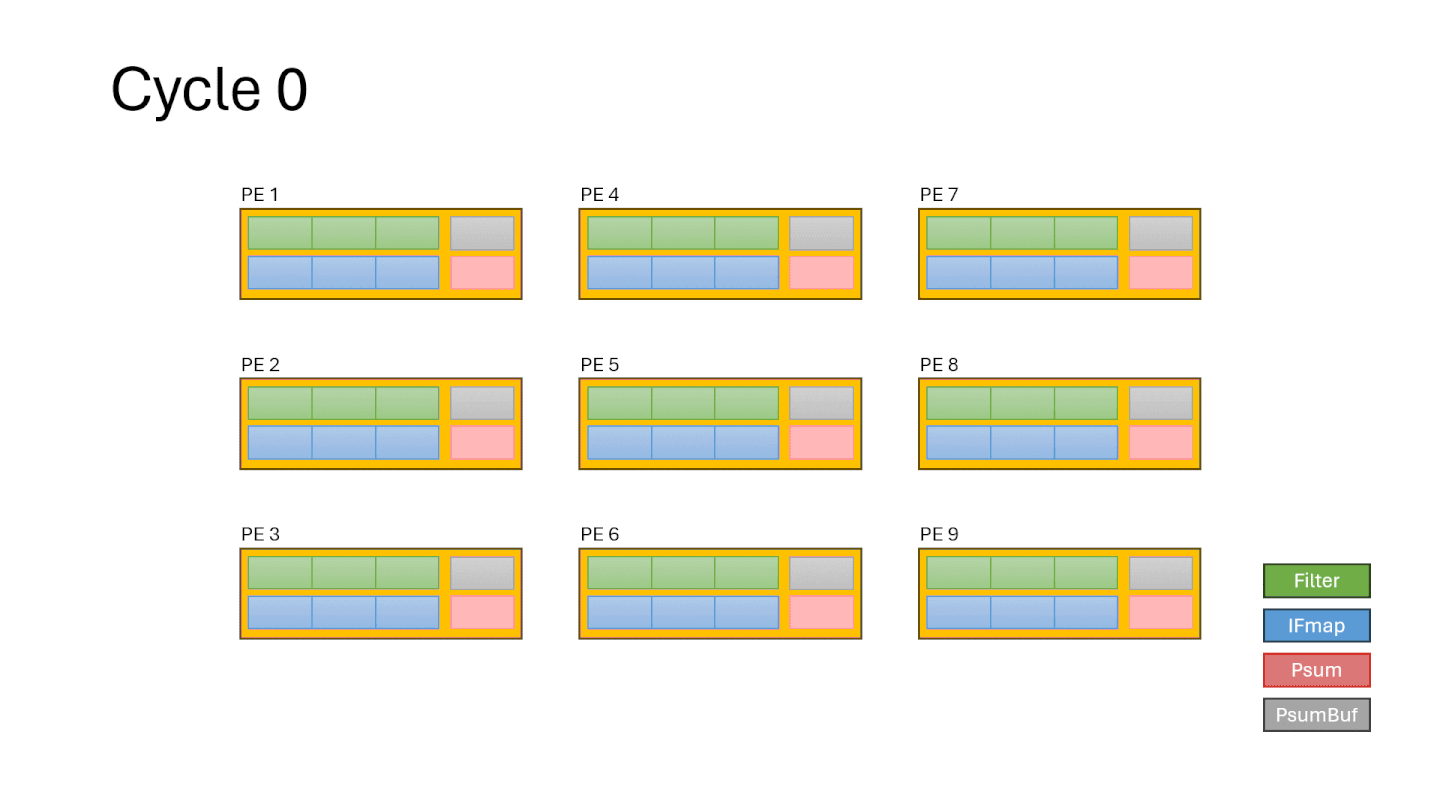

In [56]:
#@markdown In a row stationary dataflow, the individual processing elements in a systolic array each have small amounts of scratchpad memory whish is devoted to keep row value data in place while it is operated on. In this mode, each processing element computes a single output from a 1D convolution operation computed locally and then those partial sums are added down the colums for the final outputs. During the intial loading of the filter weights and row data, the full scratchpads need to be populated before any computation can occur, but as the convolution operation moves across the rows, only one new byte of data needs to be read per PE making this form of 2D convolution operation very memory efficient.
from IPython.display import Image
Image(open('/content/SystolicArray/img/systolic_array_flow.gif','rb').read())

#### What can this hardware be used for
---

### Simulation
---

In [57]:
#@title Install Dependencies {display-mode: "form"}
#@markdown Click the ▷ button to setup the simulation environment.

#@markdown Main components we will install

#@markdown *   verilator : a free and open-source software tool which converts Verilog (a hardware description language) to a cycle-accurate behavioral model in C++ or SystemC.
#@markdown *   pytorch :
#@markdown *   opencv :
#@markdown *   fxpmath : This module helps emulate the floating point math behavior of our systolic array


!apt-get install verilator
!pip install torch
!pip install torchvision
!pip install opencv-python
!pip install fxpmath
!pip install numpy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
verilator is already the newest version (4.038-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


### Compile Verilator Testbench

In [58]:
%cd /content/
!rm -rf obj_dir
!verilator --trace --cc SystolicArray/src/top.sv SystolicArray/src/topLevelControl.sv SystolicArray/src/PE.sv --exe SystolicArray/src/tb_top.cpp
!make -C obj_dir -f Vtop.mk Vtop

/content
make: Entering directory '/content/obj_dir'
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=1 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-sign-compare -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-parameter -Wno-unused-variable -Wno-shadow      -Os -c -o tb_top.o ../SystolicArray/src/tb_top.cpp
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=1 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-sign-compare -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-parameter -Wno-unused-variable -Wno-shadow      -Os -c -o verilated.o /usr/share/verilator/include/verilated.cpp
g++  -I.  -MMD -I/usr/share/verilator/include -I/usr/share/verilator/include/vltstd -DVM_COVERAGE=0 -DVM_SC=0 -DVM_TRACE=1 -faligned-new -fcf-protection=none -Wno-bool-operation -Wno-sign-compare -Wno-uninitialized -Wno-unu

### Run 2D Convolution in both Software and Hardware

In [59]:
%cd /content/SystolicArray/src/python/
!python3 full_flow.py

/content/SystolicArray/src/python
Parameter containing:
tensor([[[[-0.5000,  0.0000,  0.5000],
          [-1.0000,  0.0000,  1.0000],
          [-0.5000,  0.0000,  0.5000]]]], requires_grad=True)
Parameter containing:
tensor([[[[-0.5000, -1.0000, -0.5000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.5000,  1.0000,  0.5000]]]], requires_grad=True)
Systolic Array Result Correct: False


Text(0.5, 1.0, 'Systolic Array Edge Detection')

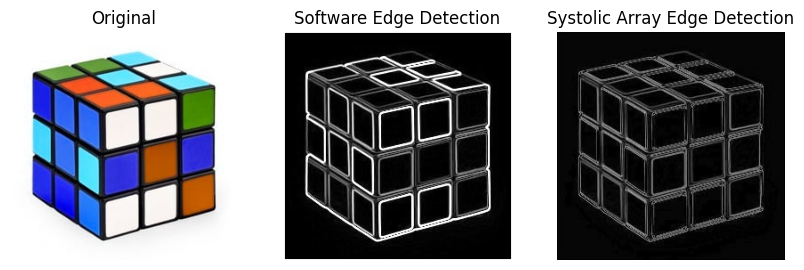

In [60]:
#@title Compare Results

#@markdown Because the hardware is limited to 8 bit integer math, the output is not as bright as the software version, but it is still able to achieve a similar looking result


# code for displaying multiple images in one figure

#import libraries
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 1
columns = 3

# reading images
Image1 = cv2.imread('/content/SystolicArray/src/python/rubiks_cube.jpg')
Image2 = cv2.imread('/content/SystolicArray/src/python/edge_rubiks_cube.jpg')
Image3 = cv2.imread('/content/SystolicArray/src/python/edge_rubiks_cube_sa.jpg')

#Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Original")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Software Edge Detection")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Systolic Array Edge Detection")


In [ ]:
#@title Install Dependencies {display-mode: "form"}
#@markdown Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

#@markdown Main components we will install

#@markdown *   Open_pdks.sky130a : a PDK installer for open-source EDA tools.
#@markdown *   Openlane : an automated RTL to GDSII flow based on several components including OpenROAD, Yosys, Magic, Netgen, CVC, SPEF-Extractor, KLayout and a number of custom scripts for design exploration and optimization.
#@markdown *   GDSTK : a C++ library for creation and manipulation of GDSII and OASIS files.

import os
import pathlib
import sys

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))

CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')

%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}

!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned

!bin/micromamba install --quiet \
                        --yes \
                        --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        open_pdks.sky130a \
                        openlane

!bin/micromamba install --quiet \
                        --yes \
                        --prefix $CONDA_PREFIX \
                        --channel conda-forge \
                        gdstk

In [ ]:
%%writefile config.json
{
    "DESIGN_NAME": "top",
    "VERILOG_FILES": "dir::SystolicArray/src/*.sv",
    "CLOCK_PERIOD": 40,
    "CLOCK_NET": "clk",
    "CLOCK_PORT": "clk",

    "FP_SIZING": "absolute",
    "DIE_AREA": "0 0 480 200",
    "PL_TARGET_DENSITY": 0.8
}

Overwriting config.json


In [ ]:
%env PDK=sky130A
!flow.tcl -design .

In [ ]:
import pathlib
import gdstk

gdss = sorted(pathlib.Path('runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gdss[-1])
top_cells = library.top_level()
top_cells[0].write_svg('systolicarray.svg')